In [1]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import os
from glob import glob
from evaluate import compute_sim, evaluate, l2norm_numpy
from evaluate import dict2list

def l2norm(embs):
    return {k: v/np.linalg.norm(v) for k, v in embs.items()}

infer_dirs = glob('infer/*')[:]
# infer_dirs = infer_dirs[1:]
infer_dirs = [x for x in infer_dirs if 'bk' not in x]
infer_dirs = [x for x in infer_dirs if 'valacc' in x]
weights = [1.0] * len(infer_dirs)
# weights = [1.0, 0.5, 0.5]

print(f"Ensemble of {len(infer_dirs)} models")

submit_file = f'submission.csv'
if os.path.exists('D:/whale_data/train_images-384-384/train_images-384-384'):
    train_img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
else:
    train_img_dir = '/Users/macbook/works/train_images-384-384'

norm=True
method = 'cat'

def get_emb(infer_dirs, subset, weights):
    li = []
    for infer_dir in infer_dirs:
        if isinstance(subset, str):
            embs = pickle_load(f"{infer_dir}/{subset}_emb.pkl")
        else:
            embs = {}
            for s in subset:
                p = f"{infer_dir}/{s}_emb.pkl"
                if os.path.exists(p):
                    embs = {**embs, **pickle_load(p)}
                elif s != "val":
                    raise FileNotFoundError(p)

        li.append(embs)

    if len(li) == 1:
        return li[0]

    print(f'Ensemble from {len(infer_dirs)} models {infer_dirs}')
    li0 = li[0]
    di = {}
    for k in li0.keys():
        di[k] = []
        for i in range(len(li)):
            e = li[i][k]
            if norm:
                e = e / np.linalg.norm(e)
            di[k].append(e)
        
        if method == 'cat':
            di[k] = np.concatenate(di[k], 0)
        else:
            # Mean
            di[k] = np.mean(di[k], 0)

    return di

train_df = pd.read_csv('data/train_kfold.csv')

train_embs = get_emb(infer_dirs, 'train', weights)
test_embs = get_emb(infer_dirs, 'test', weights)
val_embs = get_emb(infer_dirs, 'val', weights)

train_embs = l2norm(train_embs)
test_embs = l2norm(test_embs)
val_embs = l2norm(val_embs)
print(len(train_embs) + len(val_embs))

Ensemble of 1 models
51033


In [2]:
val_df = train_df[train_df.subset == 'test'].reset_index()
val_map = dict(zip(val_df.image, val_df.individual_id))
train_map = dict(zip(train_df.image, train_df.individual_id))
spec_map = dict(zip(train_df.image, train_df.species))
id_map = {**train_map, **val_map}
# val_imgs = val_df.image.unique()
# val_embs = {k: train_embs[k] for k in val_imgs}

from evaluate import compute_sim, evaluate, map_per_image, compute_simv2
from evaluate import *

score, val_sim_df = evaluate(train_df, train_embs, val_embs, norm=True)
val_sim_df["gt"] = val_sim_df.image.map(val_map)
val_sim_df["map"] = val_sim_df.apply(lambda row: map_per_image(row["gt"], row.predictions.split(" ")), axis=1)
val_sim_df = val_sim_df.sort_values("map")
print(score)

100%|██████████| 10207/10207 [00:07<00:00, 1330.04it/s]


0.320959472257601


In [3]:
train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(val_embs)
class_count_df = train_df.groupby('individual_id').size().to_frame('count').reset_index()
class_count = dict(zip(class_count_df.individual_id, class_count_df['count']))
print(train_v.shape, test_v.shape)
train_v = l2norm_numpy(train_v)
test_v = l2norm_numpy(test_v)
train_ids = np.unique([train_map[x] for x in train_k])
allowed = []
for i, k in enumerate(test_k):
    if train_map[k] in train_ids:
        allowed.append(i)
test_k, test_v = [test_k[i] for i in allowed], [test_v[i] for i in allowed]
cosines = np.matmul(test_v, train_v.T)

(40826, 512) (10207, 512)


0f58b6a8ff5ed7.jpg a8b5976b0ead


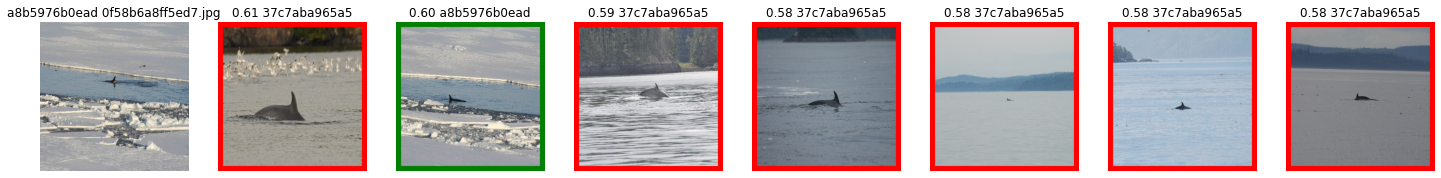

11801bc919add9.jpg b6f32c0ffd95


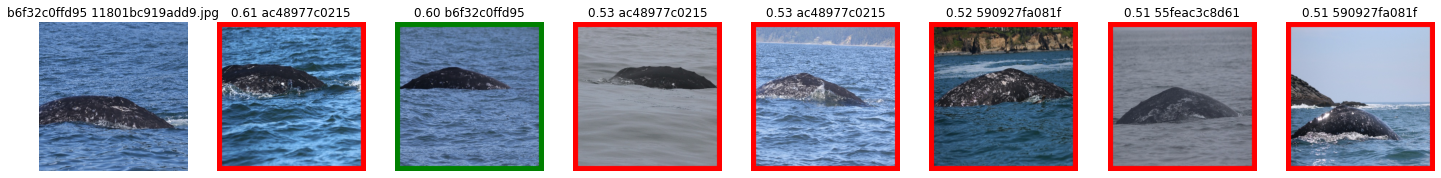

0cb959c6302212.jpg f40d4ec55697


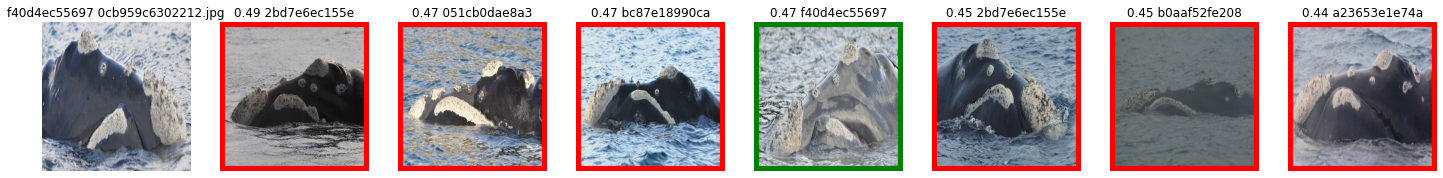

0baa7d98df9728.jpg 5a22aad0ac12


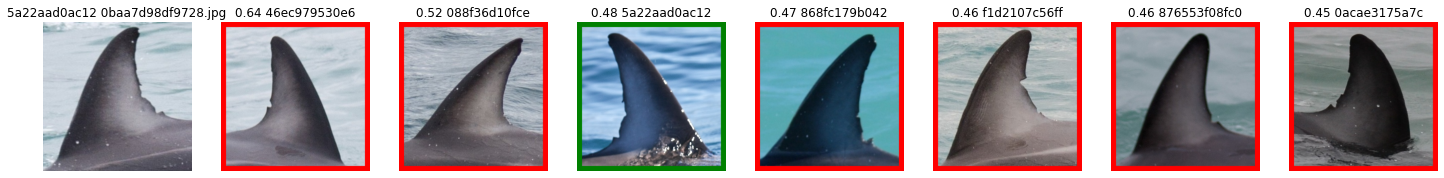

In [78]:
def add_border(img, color):
    bordersize = 14
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

c = 0
for i, scores in enumerate(cosines):
    if np.random.rand() < 0.1:
        top = 7
        sort_idx = np.argsort(-scores)
        topk = [train_k[j] for j in sort_idx[:top]]
        topk_score = [scores[j] for j in sort_idx[:top]]
        topk_id = [train_map[x] for x in topk]
        qid = test_k[i]
        gt = train_map[qid]
        if gt == topk_id[0] or gt not in topk_id[:5]:
            continue
        c+=1
        imgs = [cv2.imread(f'{train_img_dir}/{qid}')[:,:,::-1]]
        for k, l in zip(topk, topk_id):
            im = cv2.imread(f'{train_img_dir}/{k}')[:,:,::-1]
            im = add_border(im, color=(255, 0, 0) if gt != l else (0, 128, 0))
            imgs.append(im)
        # Show image
        fig = plt.figure(figsize=(25, 4))
        columns = top + 1
        rows = 1
        print(qid, gt)
        for i2 in range(0, columns*rows):
            fig.add_subplot(rows, columns, i2+1)
            plt.title(f'{gt} {qid}' if i2 == 0 else f'{topk_score[i2 - 1]:.2f} {id_map[topk[i2 -1]]}')
            plt.imshow(imgs[i2])
            plt.axis('off')
        
        plt.show()
        
    if c == 4:
        break
    

In [44]:
## TEST CV
from sklearn.neighbors import NearestNeighbors
n_neighbors = 100
knn = NearestNeighbors(n_neighbors=n_neighbors,metric='cosine')

# pred = pickle_load(infer_dirs[0] + '/test_pred.pkl')
train_k, train_v = dict2list(train_embs)
val_k, val_v = dict2list(val_embs)
knn.fit(train_v)

distances, idxs = knn.kneighbors(val_v, n_neighbors, return_distance=True)

In [45]:

from tqdm import tqdm

val_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(val_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        tar = img2id[img_id]
        val_df.append([val_k[i], tar, d]) 
    
val_df = pd.DataFrame(val_df, columns=['image', 'target', 'distances'])
val_df['confidence'] = 1-val_df['distances']
val_df = val_df.groupby(['image','target']).confidence.max().reset_index()
val_df = val_df.sort_values('confidence',ascending=False).reset_index(drop=True)
val_df.to_csv('val_neighbors.csv')
val_df.image.value_counts().value_counts()

val_pred = {}
val_conf = {}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

for i,row in tqdm(val_df.iterrows(), total=len(val_df)):
    if row.image in val_pred:
        if len(val_pred[row.image])==5:
            continue
        val_pred[row.image].append(row.target)
    elif row.confidence >= 0.5:
        val_pred[row.image] = [row.target,'new_individual']
    else:
        val_pred[row.image] = ['new_individual',row.target]

    if row.image not in val_conf:
        val_conf[row.image] = row.confidence

for x in tqdm(val_pred):
    if len(val_pred[x])<5:
        remaining = [y for y in sample_list if y not in val_pred]
        val_pred[x] = val_pred[x]+remaining
        val_pred[x] = val_pred[x][:5]
    val_pred[x] = ' '.join(val_pred[x])
    
val_pred = pd.Series(val_pred).reset_index()
val_pred.columns = ['image','predictions']
val_pred.head()

100%|██████████| 10207/10207 [00:00<00:00, 1134283.47it/s]


,image,predictions
0,05b9a41635a275.jpg,ca69a5d7c122 new_individual e4fbd6bac209 998e9...
1,165c9594c6bff7.jpg,91ed5caeb0d3 new_individual 37e09717a151 aaa7e...
2,006b2548d360a6.jpg,06ef73efe924 new_individual db095f050991 6028e...
3,05313e7265e44f.jpg,bc48b7c97463 new_individual 2b403884df6e e527f...
4,8b352b7c099490.jpg,98995caaa0d3 new_individual 027ac44f5b33 91bd0...


In [46]:
train_ids = np.unique([train_map[x] for x in train_k])
allowed = []
for i, k in enumerate(val_k):
    if train_map[k] in train_ids:
        allowed.append(train_map[k])

val_targets_df = pd.DataFrame(val_k)
val_targets_df.columns = ['image']
val_targets_df['target'] = val_targets_df['image'].map(train_map)
val_targets_df.loc[~val_targets_df.target.isin(allowed),'target'] = 'new_individual'
val_targets_df['conf'] = val_targets_df['image'].map(val_conf)
val_targets_df.head(10)

all_preds = dict(zip(val_pred['image'], val_pred['predictions']))
th = 0.5
for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image].split(" ")
        val_targets_df.loc[i,th] = map_per_image(target,preds)
        val_targets_df.loc[i, 'preds'] = all_preds[row.image]
cv = val_targets_df[th].mean()
print(cv)
val_targets_df.head(2)

0.7597808693380359


,image,target,conf,0.5,preds
0,00021adfb725ed.jpg,new_individual,0.510476,0.5,5f9312174b87 new_individual 8bb8b7b094da 176c0...
1,108078c210e47e.jpg,1b434f154c89,0.712039,1.0,1b434f154c89 new_individual e15af078327f 8c00b...


In [61]:
len(val_targets_df[val_targets_df[0.5] == 0.0 ]) / len(val_targets_df)

0.117664347996473